## 1. Packges included

In [1]:
import pandas as pd
from pandas import *
import numpy as np
import os
from datetime import *
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import csv
from zipfile import ZipFile
import math
import collections
import filecmp
import xml.etree.ElementTree as ET
import geopandas as gpd
from shapely import wkt

SUMO network 
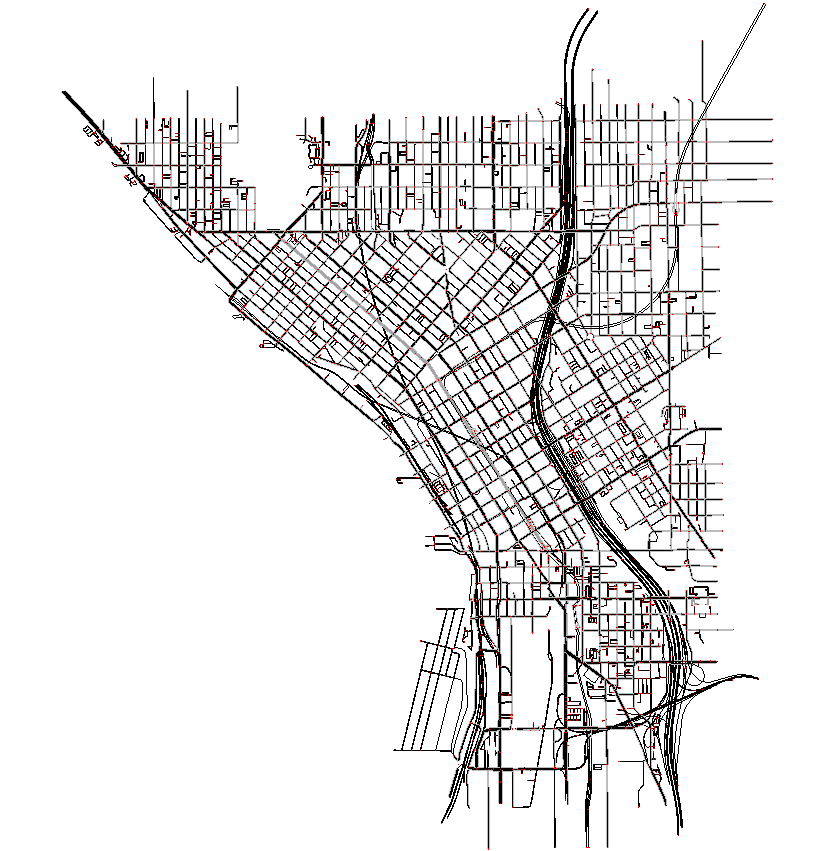

## sumo OD data processing
### i. defining functions

In [1]:
#assign value to specific od
#aggreagate taz
def convert_od_file(od_filepath, psrc_taz, pseudo_taz_file):
    psrc_ods = pd.read_csv(od_filepath)
    psrc_ods.columns = ['O','D','demand']
    # for nearby north and south taz
    # aggregate their neighbor taz to them
    
    #since the demand from the ferry is not very  much (< 25 per od pair)
    #we exclud the ferry demand
    excluded_ferry_taz = [445, 449, 478, 610, 633]
    #check the demand
    #for i in excluded_ferry_taz:
    #    print(i)
    #    print(np.sum(psrc_ods['demand'][psrc_ods['D']==i].values))
    #    print(np.sum(psrc_ods['demand'][psrc_ods['O']==i].values))

    psrc_ods = psrc_ods[~psrc_ods['O'].isin(excluded_ferry_taz)]
    psrc_ods = psrc_ods[~psrc_ods['D'].isin(excluded_ferry_taz)]
    
    datapath = '../Taz_bigger_Seattle_all_transit_with_pseudo_link.add.xml'
    tree = ET.parse(datapath)
    root = tree.getroot()
    sumo_taz = []
    for taz in root.findall('taz'):
        tazid = taz.get('id')
        sumo_taz.append(tazid)
    
    #create taz map
    taz_map = {}
    
    #print('checkids')
    taz_map = assign_to_taz([444], 446, taz_map, sumo_taz)
    taz_map = assign_to_taz([395, 396, 397, 398], 442, taz_map, sumo_taz)
    taz_map = assign_to_taz([399, 400], 440, taz_map, sumo_taz)
    taz_map = assign_to_taz([401, 402], 436, taz_map, sumo_taz)
    taz_map = assign_to_taz([403], 434, taz_map, sumo_taz)
    taz_map = assign_to_taz([405], 432, taz_map, sumo_taz)
    taz_map = assign_to_taz([407], 427, taz_map, sumo_taz)
    taz_map = assign_to_taz([408], 426, taz_map, sumo_taz)
    taz_map = assign_to_taz([633], 610, taz_map, sumo_taz)
    taz_map = assign_to_taz([655], 653, taz_map, sumo_taz)
    taz_map = assign_to_taz([656], 652, taz_map, sumo_taz)
    taz_map = assign_to_taz([657], 650, taz_map, sumo_taz)
    #print('manual check end')

    #convert sumotaz to int
    for i in range(len(sumo_taz)):
        if 'taz' not in sumo_taz[i]:
            sumo_taz[i] = int(sumo_taz[i])

    reassigned_taz = list(taz_map.keys())
    sumo_taz.extend(reassigned_taz)
    
    pseudo_loc = pseudo_taz_file['location'].values.T
    pseudotazs = pseudo_taz_file['pseudo_id'].values.T
    pseudo_mapping = {}
    for i in range(int(len(pseudo_loc)/2)):
        index_num = i*2
        loc = pseudo_loc[index_num][:-2]
        pseudo_mapping[loc] = []
        pseudo_mapping[loc].append(pseudotazs[index_num])
        pseudo_mapping[loc].append(pseudotazs[index_num+1])
    # pseudo_mapping = {I-5N:[5000, 5001], I-5S:[5002, 5003], ...}
    
    psrc_taz = psrc_taz[~psrc_taz['TAZ'].isin(excluded_ferry_taz)]
    lat_val = psrc_taz['lat'].values.T
    lon_val = psrc_taz['lon'].values.T
    tazs = psrc_taz['TAZ'].values.T
    
    #set up criteria to identify variables
    #for lat, the larger, the higher; for lon, the larger, the more right
    SR99N = [23.421669, 126.923911]
    I5N = [23.268797,  126.923911]
    East = [[23.102587, 128.492278],[22.09419, 128.492278]]
    I90 = [[21.981049, 127.666997],[14.21359,145.35695]]
    SR99S = [[21.367705, 126.803996],[16.068982,127.22979]]
    # I5S? last line of if statement
    
    for i in range(len(tazs)):
        if tazs[i] not in sumo_taz:
            #sr99N
            if lat_val[i]>= SR99N[0] and lon_val[i]<=SR99N[1]:
                taz_map[tazs[i]] = 'SR-99N'
            #I5N
            elif lat_val[i]>= I5N[0] and lon_val[i]>=I5N[1]:
                taz_map[tazs[i]] = 'I-5N'
            #East
            elif lat_val[i]<=East[0][0] and lat_val[i]>=East[1][0] and lon_val[i]<=East[0][1]:
                taz_map[tazs[i]] = 'East'
            elif lat_val[i]<=I90[0][0] and lat_val[i]>=I90[1][0] and lon_val[i]>=I90[0][1] and lon_val[i]<=I90[1][1]:
                taz_map[tazs[i]] = 'I-90'
            elif lat_val[i]<=SR99S[0][0] and lat_val[i]>=SR99S[1][0] and lon_val[i]>=SR99S[0][1] and lon_val[i]<=SR99S[1][1]:
                taz_map[tazs[i]] = 'SR-99S'
            else:
                taz_map[tazs[i]] = 'I-5S'

    psrc_ods = psrc_ods[psrc_ods['O'].isin(tazs)]
    psrc_ods = psrc_ods[psrc_ods['D'].isin(tazs)]
    
    #convert od files
    ori = psrc_ods['O'].values.T
    dest = psrc_ods['D'].values.T

    convert_ori = []
    convert_dest = []
    convert_taz = list(taz_map.keys())

    for i in range(len(ori)):
        if ori[i] in convert_taz:
            mapped_dir = taz_map[ori[i]]
            if type(mapped_dir) == int:
                convert_ori.append(mapped_dir)
            else:
                convert_ori.append(pseudo_mapping[mapped_dir][0])
        else:
            convert_ori.append(ori[i])

        if dest[i] in convert_taz:
            mapped_dir = taz_map[dest[i]]
            if type(mapped_dir) == int:
                convert_dest.append(mapped_dir)
            else:
                convert_dest.append(pseudo_mapping[mapped_dir][1])
        else:
            convert_dest.append(dest[i])
            
    psrc_ods['cO'] = convert_ori
    psrc_ods['cD'] = convert_dest
    
    return(psrc_ods, taz_map)


 #### don't forget to delete demands that do not take place within downtown


In [ ]:
def save_revised_od_file(od_dt, save_path):
    od_dt = od_dt[['cO','cD','demand']]
    od_dt.to_csv(save_path, index=False)

#create different sumo demand
def assign_per_to_od(file_path):
    od = pd.read_csv(file_path)
    percentage_check = list(range(1,10))
    percentage_check = 0.05*np.array(percentage_check)

    for percent in percentage_check:
        colnames = list(od.columns)[-1]
        data_col = list(od.columns)[:2]
        demand = (1-percent)*od[[colnames]].values
        demand = np.rint(demand)
        colnames = colnames+'_minus_'+str(int(percent*100))+'per'
        od[colnames] = demand
        data_col.append(colnames)
        od[data_col].to_csv(file_path[:-4]+str(int(percent*100))+'per'+file_path[-4:], index=False)
    print('od assigned done')

def check_taz_ids(ids, sumo_taz):
    return(ids in sumo_taz)

def assign_to_taz(taz, assigned_taz, taz_map, sumo_taz):
    for i in taz:
        if check_taz_ids(i, sumo_taz) == True:
            print('warning, taz already in sumo')
        else:
            if i not in taz_map:
                taz_map[i] = assigned_taz
    return(taz_map)

### ii. Making the changes

In [2]:
#read and revise od data
#load the pseudo taz
pseudo_taz = pd.read_csv('pseudo_taz.csv')

#get information we need
#get taz file
# os.chdir(pathfile)
datapath = 'Taz_bigger_Seattle_all_transit.add.xml'
tree = ET.parse(datapath)
root = tree.getroot()
selected_taz = []
for taz in root.findall('taz'):
    tazid = taz.get('id')
    selected_taz.append(tazid)
for i in range(len(selected_taz)):
    selected_taz[i] = int(selected_taz[i])

#other data processing
#get downtown Seattle taz in sumo
#get information we need

#read taz data
psrc_taz = gpd.read_file('taz2010.shp')

#get centroid points from taz
lat_psrc = []
lon_psrc = []
for polys in psrc_taz['geometry'].values:
    p = wkt.loads(str(polys))
    latlon = p.centroid.wkt
    latlon = latlon[5:].split(' ')
    lon = float(latlon[1][1:])
    lat = float(latlon[2][:-1])
    lat_psrc.append(lat)
    lon_psrc.append(lon)

psrc_taz['lat'] = lat_psrc
psrc_taz['lon'] = lon_psrc

psrc_taz['lat'] = psrc_taz['lat']/10000
psrc_taz['lon'] = psrc_taz['lon']/10000
psrc_taz.head(3)

FileNotFoundError: [Errno 2] No such file or directory: 'Taz_bigger_Seattle_all_transit.add.xml'

In [37]:
#taz map is the converted taz in SUMO based on all the taz in PSRC
od_wh, taz_map  = convert_od_file('veh_od_psrc_wh.csv', psrc_taz, pseudo_taz_file=pseudo_taz)
save_revised_od_file(od_wh, 'od_wh.csv')

In [3]:
psrc_taz = gpd.read_file('taz2010.shp')
print(psrc_taz.crs)

PROJCS["NAD83(HARN) / Washington North (ftUS)",GEOGCS["NAD83(HARN)",DATUM["NAD83_High_Accuracy_Reference_Network",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6152"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",47],PARAMETER["central_meridian",-120.833333333333],PARAMETER["standard_parallel_1",47.5],PARAMETER["standard_parallel_2",48.7333333333333],PARAMETER["false_easting",1640416.66666667],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [7]:
#set up criteria to identify variables
#for lat, the larger, the higher; for lon, the larger, the more right
SR99N = [23.421669, 126.923911]
I5N = [23.268797,  126.923911]
East = [[23.102587, 128.492278],[22.09419, 128.492278]]
I90 = [[21.981049, 127.666997],[14.21359,145.35695]]
SR99S = [[21.367705, 126.803996],[16.068982,127.22979]]
for i in [SR99N, I5N, East, I90, SR99S]:
    print('***')
    if type(i[0])==list:
        for j in i:
            print(f"qgis coordinate: {str(j[1]*10000) + ', ' + str(j[0]*10000)}")
    else:
            print(f"qgis coordinate: {str(i[1]*10000) + ', ' + str(i[0]*10000)}")
        


***
qgis coordinate: 1269239.11, 234216.69
***
qgis coordinate: 1269239.11, 232687.97
***
qgis coordinate: 1284922.78, 231025.87
qgis coordinate: 1284922.78, 220941.90000000002
***
qgis coordinate: 1276669.97, 219810.49
qgis coordinate: 1453569.5000000002, 142135.9
***
qgis coordinate: 1268039.96, 213677.05000000002
qgis coordinate: 1272297.9, 160689.81999999998
